# Codes

In [6]:
import numpy as np
import matplotlib.pyplot as plt

class Simplex(object):
    def __init__(self, obj, b_matrix=[], method='greedy', maxloop=2000, max_mode=False):
        self.mat, self.max_mode = np.array(
            [[0] + obj]) * (-1 if max_mode else 1), max_mode
        if b_matrix != []:
            self.mat = np.vstack([self.mat, b_matrix])
        self.count = 0
        self.maxloop = maxloop
        self.log = []
        self.method = method

    def _pivot(self, mat, B, row, col):
        mat[row] /= mat[row][col]
        ids = np.arange(mat.shape[0]) != row
        # for each i!= row do: mat[i]= mat[i] - mat[row] * mat[i][col]
        mat[ids] -= mat[row] * mat[ids, col:col + 1]
        B[row] = col
        self.count += 1
        self.log.append(mat[0][0])

    def _simplex(self, mat, B, m, n):
        while mat[0, 1:].min() < 0 and self.count < self.maxloop:
            if self.method == "greedy":
                delta = []
                for col in (np.where(mat[0, 1:] < 0)[0] + 1):
                    row = np.array([mat[i][0] / mat[i][col] if mat[i][col] > 0 else 0x7fffffff for i in 
                                    range(1, mat.shape[0])]).argmax() + 1
                    delta.append(-mat[0][col]/mat[row][col]*mat[row][0])
            
                col = (np.where(mat[0, 1:] < 0)[0] + 1)[np.array(delta).argmin()]
            elif self.method == "Dantzig":
                col = mat[0, 1:].argmin() + 1
            else:
                col = np.where(mat[0, 1:] < 0)[0][0] + 1
                
            row = np.array([mat[i][0] / mat[i][col] if mat[i][col] > 0 else 0x7fffffff for i in 
                range(1, mat.shape[0])]).argmin() + 1
            
            if mat[row][col] <= 0:
                return None  # the theta is ∞, the problem is unbounded
            self._pivot(mat, B, row, col)
        # print('loop:', self.count)
        return mat[0][0] * (1 if self.max_mode else -1), {B[i]: mat[i, 0] for i in range(1, m) if B[i] < n}

    def solve(self):
        m, n = self.mat.shape  # m - 1 is the number slack variables we should add
        temp, B = np.vstack([np.zeros((1, m - 1)), np.eye(m - 1)]
                            ), list(range(n - 1, n + m - 1))  # add diagonal array
        mat = self.mat = np.hstack([self.mat, temp])  # combine them!
        if mat[1:, 0].min() < 0:  # is the initial basic solution feasible?
            row = mat[1:, 0].argmin() + 1  # find the index of min b
            # set first row value to zero, and store the previous value
            temp, mat[0] = np.copy(mat[0]), 0
            mat = np.hstack(
                [mat, np.array([1] + [-1] * (m - 1)).reshape((-1, 1))])
            self._pivot(mat, B, row, mat.shape[1] - 1)
            if self._simplex(mat, B, m, n)[0] != 0:
                return None  # the problem has no answer
            if mat.shape[1] - 1 in B:  # if the x0 in B, we should pivot it.
                self._pivot(mat, B, B.index(
                    mat.shape[1] - 1), np.where(mat[0, 1:] != 0)[0][0] + 1)
            # recover the first line
            self.mat = np.vstack([temp, mat[1:, :-1]])
            for i, x in enumerate(B[1:]):
                self.mat[0] -= self.mat[0, x] * self.mat[i + 1]
        return self._simplex(self.mat, B, m, n), self.log

# Test: 

In [21]:
data = np.loadtxt("Data/data_share1b.txt", dtype=int)
Z = list(data[0][1:])
B = list(data[1:])

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars


loop: 162
z: 36703.67432404849
Wall time: 514 ms


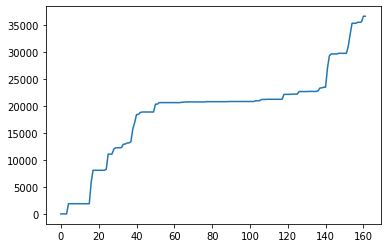

In [22]:
%%time
test = Simplex(Z, B)
ptsd, log = test.solve()
plt.plot(log)
print('loop:',len(log))
print("z:",log[-1])
# print(log)
log_greedy = log

loop: 121
z: 592505.0107601287
Wall time: 44.9 ms


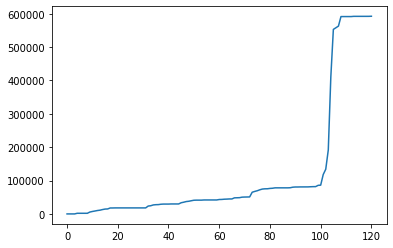

In [23]:
%%time
test = Simplex(Z, B, "Dantzig")
ptsd, log = test.solve()
plt.plot(log)
print('loop:',len(log))
print("z:",log[-1])
# print(log)

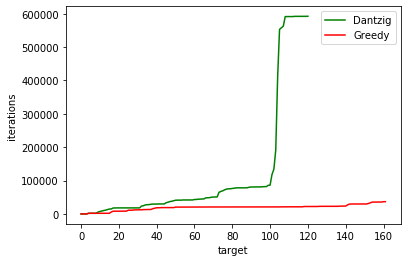

In [24]:
num = min(len(log_greedy), len(log))
plt.plot(range(len(log)), log, color='green', label='Dantzig')
plt.plot(range(len(log_greedy)), log_greedy, color='red', label='Greedy')
plt.xlabel('target')
plt.ylabel('iterations')
plt.legend()

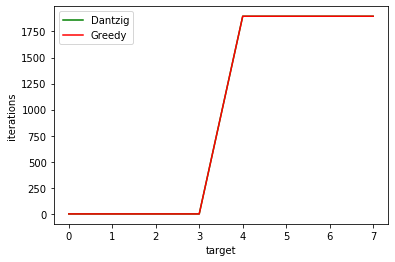

In [27]:
num = min(len(log_greedy), len(log), 8)
plt.plot(range(num), log[:num], color='green', label='Dantzig')
plt.plot(range(num), log_greedy[:num], color='red', label='Greedy')
plt.xlabel('target')
plt.ylabel('iterations')
plt.legend()